## Same thing but Poisson

In [1]:
# %matplotlib widget
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
np.random.seed(42)

In [2]:
K = 10
a, b = 0.1, 1.3
N_train = 80
N_test = 20
var = 0.5

In [3]:
theta_true = np.ones(K)
X_train = np.linspace(a, b, N_train)
X_test = np.random.uniform(a, b, N_test)
print("X_train shape :{}, X_test shape :{}".format(X_train.shape, X_test.shape))

X_train shape :(80,), X_test shape :(20,)


In [4]:
def phi_func(x, k):
    return np.power(x, np.arange(0, k))

def get_y_from_x(x, k, theta):
    if x.shape[0] > 2:
        return np.array([np.random.poisson(phi_func(x_i, k) @ theta) for x_i in x])
    else:
        return np.random.poisson(phi_func(x, k) @ theta)

In [5]:
Y_train = get_y_from_x(X_train, K, theta_true)
Y_test = get_y_from_x(X_test, K, theta_true)
print("Y_train shape :{}, Y_test shape :{}".format(Y_train.shape, Y_test.shape))


Y_train shape :(80,), Y_test shape :(20,)


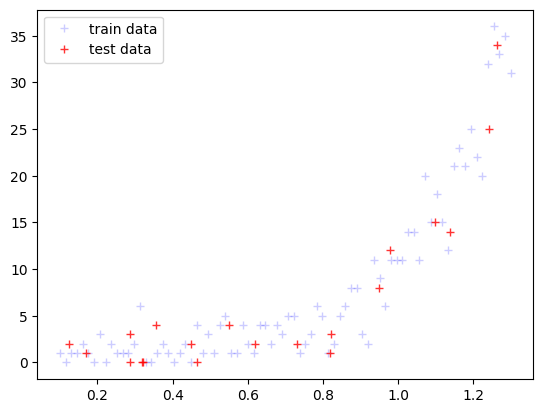

In [6]:
plt.plot(X_train, Y_train, "+b", alpha=0.2, label="train data")
plt.plot(X_test, Y_test, "+r", alpha=0.8, label="test data")
plt.legend()
plt.show()

If $Poi(y|\lambda)=\frac{\lambda^y e^{-\lambda}}{y!}$ for one sample, then the negative log likelyhood is $$L(\lambda) = \sum_i^N [-y_i\log{\lambda} + \lambda + \log{(y_i!)}]$$

$\lambda$ in our case was defined as $\phi(x_i) \theta$, where $\phi$ is $[1, x_i, x_i^2, ..., x_i^{K-1}]^T$ and $\theta$ are the parameters of our regressor.

So it becomes: $$L(\theta) = \sum_i^N [-y_i\log{(\phi(x_i)\theta)} + \phi(x_i)\theta + const]$$

Putting the derivative = 0 results in: $$\sum_i^N [\phi(x_i) + y_i \phi(x_i) * \frac{1}{\phi(x_i)\theta}] = 0$$

$$\sum_i^N [\phi(x_i) (1 + y_i * \frac{1}{\phi(x_i)\theta})] = 0$$

Unfortunately, if we tried to write it in matrix form, it wouldn't be so easy because the derivative of the logarithm is defined only for $$dA A = A dA$$

If we defined $\Phi(X)$ as the vandermonde matrix $\Phi \in \mathbb{R}^{N \times K}$

We could see that $$\Phi(X)  [\Phi(X)\theta] \ne [\Phi(X)\theta]  \Phi(X)$$

because of the dimensions mismatch.

However we can still use $$\sum_i^N [\phi(x_i) (1 + y_i * \frac{1}{\phi(x_i)\theta})]$$

as a gradient in a gradient descent method.

In [16]:
def gradient(theta, x, y, k):
    if x.shape[0] > 1:
        gradients = []
        for x_i, y_i in zip(x, y):
            phi = phi_func(x_i, k)
            gradients.append(phi*(1-y_i/(phi @ theta)))
        return gradients
    else:
        phi = phi_func(x, k)
        return phi*(1-y/(phi @ theta))

def predict(x, k, theta):
    if x.shape[0] > 1:
        return np.array([phi_func(x_i, k) @ theta for x_i in x])
    else:
        return phi_func(x, k) @ theta

# even if not minimizing the MSE, it still is a good indicator of the performance of the weights
def MSE_loss(theta, x, y, k):
    return np.mean((predict(x, k, theta) - y)**2)

In [21]:
def is_fininshed(grad_f, wk, wk_1, w0, X, Y, k, tolf, tolx):

    flag_rel = np.linalg.norm(grad_f(wk, X, Y, k))**2 < (tolf * np.linalg.norm(grad_f(w0, X, Y, k))**2)
    flag_abs = np.linalg.norm(wk-wk_1)**2 < tolx
    return flag_rel and flag_abs


def SGD(loss_func, grad_func, k, w0, data, batch_size, n_epochs):
    '''
    Applies SGD on a logistic regressor with MSE loss
    If batch_size is set to -1, we configure it as normal GD with stopping conditions
    '''
    alpha = 1e-2

    X, Y = data

    w = [w0]
    loss_val = []
    grads_val = []
    err_val = []

    ### only useful for GD
    tolx = 1e-6
    tolf = 1e-6
    # set up for normal GD
    if batch_size == -1:
        batch_size = len(Y)
        n_epochs = 100
    ###

    for epoch in range(n_epochs):
        indeces = np.arange(len(Y))
        np.random.shuffle(indeces)
        X = X[indeces]
        Y = Y[indeces]

        for i in range(0, len(Y), batch_size):
            batch_X = X[i:i+batch_size]
            batch_Y = Y[i:i+batch_size]
            new_weights = w[-1] - alpha*np.mean(grad_func(w[-1], batch_X, batch_Y, k))
            w.append(new_weights)

        loss_val.append(loss_func(w[-1], X, Y, k))
        grads_val.append(grad_func(w[-1], X, Y, k))
        err_val.append(np.linalg.norm(grads_val[-1])**2)

        # GD convergence check
        if batch_size == len(Y):
            if is_fininshed(grad_func, w[-1], w[-2], w[0], X, Y, k, tolf, tolx):
                break
    
    return w,loss_val, grads_val, err_val

In [22]:
w_GD, loss_val, grads_val, err_val = SGD(MSE_loss, gradient, K, np.random.normal(size=K), (X_train, Y_train), -1, 150)
theta_GD = w_GD[-1]


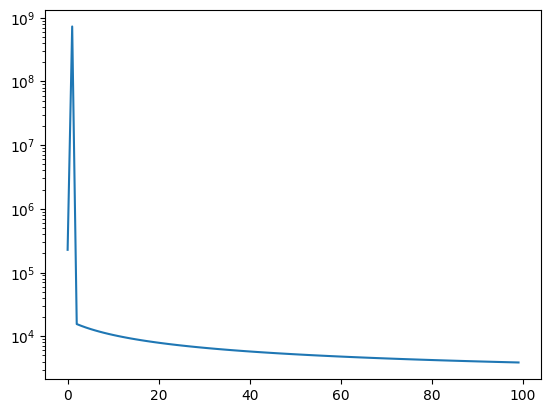

In [23]:
_, ax = plt.subplots(1, 1)
ax.plot(err_val)
ax.set_yscale("log")

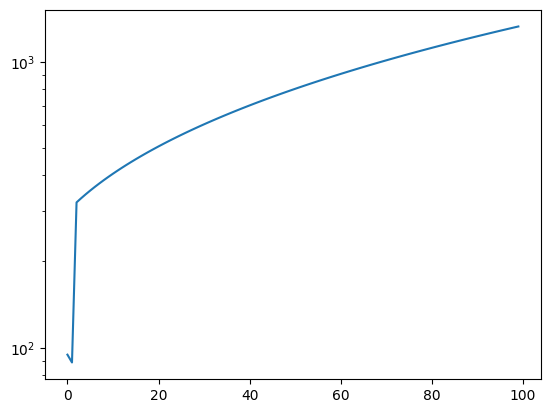

In [24]:
_, ax = plt.subplots(1, 1)
ax.plot(loss_val)
ax.set_yscale("log")

In [ ]:
_, ax = plt.subplots(1, 1)
ax.plot(loss_val)
ax.set_yscale("log")